# Feature Extraction

Incoming EEG signal is modelled by ARs and the AR coefficients will form our feature vector.

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# %matplotlib osx

In [3]:
# %matplotlib widget

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'

In [3]:
# Summary
# File Name: chb01_03.edf
# File Start Time: 13:43:04
# File End Time: 14:43:04
# Number of Seizures in File: 1
# Seizure Start Time: 2996 seconds
# Seizure End Time: 3036 seconds
raw = mne.io.read_raw_edf(input_fname=os.path.join(root, os.listdir(root)[3]), preload=False, verbose='Error')
ch_names = raw.info['ch_names'] # array of channel names

To observe the response of the AR coefficients, we select subsets from this 1 hour recording which contains 1 seizure. We will sample the following subsets:

- Full seizure period
- Normal period
- Transition from normal to seizure
- Transition from seizure to normal

In [6]:
# sample the seizure (ictal) clip
seizure_start_time = 2996 # in seconds
seizure_end_time = 3036
seizure_duration = seizure_end_time - seizure_start_time
EEG_ictal, times_ictal = raw.copy() \
                        .crop(tmin=seizure_start_time, tmax=seizure_end_time) \
                        .get_data(picks=['eeg'], units='uV', return_times=True) # EEG units in micro-volts (uV)
print(f'Start: {seizure_start_time}s, End: {seizure_end_time}s')
print(f'Duration: {np.max(times_ictal) - np.min(times_ictal)}s')

Start: 2996s, End: 3036s
Duration: 40.0s


In [4]:
# sample a normal (interictal) clip of length similar to seizure
interictal_start_time = 720 # in seconds
interictal_end_time = interictal_start_time + 40
EEG_interictal, times_interictal = raw.copy() \
                            .crop(tmin=interictal_start_time, tmax=interictal_end_time) \
                            .get_data(picks=['eeg'], units='uV', return_times=True)
print(f'Start: {interictal_start_time}s, End: {interictal_end_time}s')
print(f'Duration: {np.max(times_interictal) - np.min(times_interictal)}s')
print(f'Dimensions: {EEG_interictal.shape}')

Start: 720s, End: 760s
Duration: 40.0s
Dimensions: (23, 10241)


In [8]:
# sample the start boundary of seizure (20s before seizure start and 20s after seizure start)
EEG_ictal_start, times_ictal_start = raw.copy() \
                            .crop(tmin=seizure_start_time-20, tmax=seizure_start_time+20) \
                            .get_data(picks=['eeg'], units='uV', return_times=True)
print(f'Start: {seizure_start_time-20}s, End: {seizure_start_time+20}s')
print(f'Duration: {np.max(times_ictal_start) - np.min(times_ictal_start)}s')

Start: 2976s, End: 3016s
Duration: 40.0s


In [9]:
# sample the end boundary of seizure (20s before seizure end and 20s after seizure end)
EEG_ictal_end, times_ictal_end = raw.copy() \
                                    .crop(tmin=seizure_end_time-20, tmax=seizure_end_time+20) \
                                    .get_data(picks=['eeg'], units='uV', return_times=True)
print(f'Start: {seizure_end_time-20}s, End: {seizure_end_time+20}s')
print(f'Duration: {np.max(times_ictal_end) - np.min(times_ictal_end)}s')

Start: 3016s, End: 3056s
Duration: 40.0s


In [28]:
# plot signal streaming as if 'real time'
ch_idx = 0 # select channel by index
fig = plt.figure()
ax = plt.axes(xlim=(np.min(times), np.max(times)), 
              ylim=(np.min(EEG_ictal_start[ch_idx,:])*1.5, np.max(EEG_ictal_start[ch_idx,:])*1.5))

xs = []
ys = []
line, = ax.plot([], [], 'tab:purple', lw=2)
ax.axvline(x=10, color='gray', ls='--') # mark seizure onset

def animate(i, xs, ys):
    Ik = (i-1)*512+1
    timebuf = times[i:i+5]
    sigbuf = EEG_ictal_start[0,i:i+5]
    
    
    xs.append(timebuf)
    ys.append(sigbuf)
    line.set_data(xs, ys)
    return line,

anim = animation.FuncAnimation(fig, animate, fargs=(xs, ys),
                               interval=5, blit=True)
plt.xlabel('Time, s')
plt.ylabel(r'Potential Difference, $\mu V$')
plt.title(f'Electrode: {ch_names[ch_idx]}')
plt.show()

In [5]:
fs = raw.info['sfreq']   # sampling frequency
N = 512*3                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 6                  # AR order
t_s = 1/fs
print('N:', N)
print(f'AR({n_i})')

N: 1536
AR(6)


Run a sliding window on the interictal clip to observe AR coefficient response. 

In [6]:
np.random.seed(42)
a_hats = []

k=1
Ik_0 = (k-1)*N+1 # compute window start index
K = np.rint(len(EEG_interictal[0,:])).astype(int) # total number of time steps
window_slides_count = (K/N).astype(int)
print('Window width:', N*t_s, 's')
print(f'Total windows: {window_slides_count-2}')
print('---')
X = EEG_interictal[0,:]
a = np.random.randn(n_i).reshape(-1, 1) # AR parameters
for k in range(2, window_slides_count):
    Ik = np.rint((k-1)*N+1).astype(int) # compute window end index
    print(f'wStart: {Ik_0}, wEnd: {Ik}')
    phi = X[Ik-n_i:Ik].reshape(-1, 1)  # regressors from time t going back to t-n_i
    print('phi:\n', phi, phi.shape)
    print('a:\n', a, a.shape)
    
    # what should the dimension of a_hat be: (1, 1) or (1, 6)?
    # if (1, 6) then
    # e_t = np.random.randn(6,1) # error signal
    # x_t = phi @ a.T + e_t
    # a_hat = np.linalg.inv(phi.T@phi) @ (phi.T@x_t)
    
    # if (1, 1) then
    e_t = np.random.randn(1,1) # error signal
    x_t = phi.T @ a + e_t
    a_hat = np.linalg.inv(phi@phi.T) @ (phi@x_t)
    a_hats.append(a_hat.squeeze())
    print('e:', e_t, e_t.shape)
    print('x_t:', x_t, x_t.shape)
    print('a_hat:\n', a_hat, a_hat.shape)
    
    Ik_0 = Ik # old window end index becomes new window start index
    print('Window:', k-1)
    print('--')

Window width: 6.0 s
Total windows: 4
---
wStart: 1, wEnd: 1537
phi:
 [[-60.75702076]
 [-50.20757021]
 [-40.83028083]
 [-38.87667888]
 [-35.36019536]
 [-34.96947497]] (6, 1)
a:
 [[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]
 [-0.23415337]
 [-0.23413696]] (6, 1)
e: [[1.57921282]] (1, 1)
x_t: [[-90.8460367]] (1, 1)
a_hat:
 [[-7.]
 [ 0.]
 [-5.]
 [ 3.]
 [16.]
 [ 4.]] (6, 1)
Window: 1
--
wStart: 1537, wEnd: 3073
phi:
 [[55.67765568]
 [57.63125763]
 [59.58485958]
 [52.55189255]
 [47.86324786]
 [47.47252747]] (6, 1)
a:
 [[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]
 [-0.23415337]
 [-0.23413696]] (6, 1)
e: [[0.76743473]] (1, 1)
x_t: [[116.76308658]] (1, 1)
a_hat:
 [[ 1. ]
 [-4. ]
 [ 4. ]
 [-4.5]
 [ 2. ]
 [-3. ]] (6, 1)
Window: 2
--
wStart: 3073, wEnd: 4609
phi:
 [[17.77777778]
 [28.32722833]
 [43.17460317]
 [50.98901099]
 [60.36630037]
 [74.43223443]] (6, 1)
a:
 [[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]
 [-0.23415337]
 [-0.23413696]] (6, 1)
e: [[-0.

In [7]:
a_hats_ndarr = np.array(a_hats)
a_hats_ndarr

array([[  -7.   ,    0.   ,   -5.   ,    3.   ,   16.   ,    4.   ],
       [   1.   ,   -4.   ,    4.   ,   -4.5  ,    2.   ,   -3.   ],
       [   4.   ,    4.   ,    0.   ,    0.   ,   -0.875,   -1.   ],
       [   0.   ,   30.   ,  -16.   , -128.   ,   -2.   ,   32.   ]])

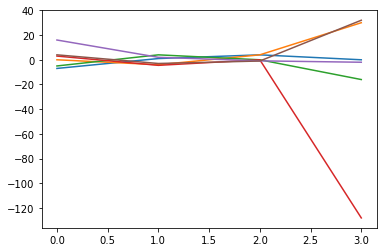

In [8]:
# visualise a_hat changes
plt.plot(np.arange(0,4), a_hats_ndarr)
plt.show()

In [15]:
Ik_init = (1-1)*N+1
print(f'Window length: {N/fs}s')
print(Ik_init)
for i in range(2, 6):
    Ik = (i-1)*N+1
    print(f'i:{i}, Ik:{Ik}, dif:{Ik - Ik_init}')
    Ik_init = Ik

Window length: 2.0s
1
i:2, Ik:513, dif:512
i:3, Ik:1025, dif:512
i:4, Ik:1537, dif:512
i:5, Ik:2049, dif:512


In [13]:
print(f'Window length: {N/fs}s')
X = EEG[0,:]
Ik_buf = (1-1)*N+1
ARs = []
for k in range(2, np.rint(len(X)/N).astype(int)):
    Ik = (k-1)*N+1
    print('Ik:', Ik)
    sigbuf = X[Ik_buf:Ik]
    print('sigbuf.shape:', sigbuf.shape)
    print(f'Window {k-1} size:', sigbuf.shape)
    AR_order = 6 # AR(6) model
    A = np.random.randn(AR_order) # a_j: init AR coeffs from Norm. Dist.
    AR_sigbuf = sigbuf[len(sigbuf)-6:len(sigbuf)] # x_t-j
    print('AR_sigbuf.shape:', AR_sigbuf.shape)
    E = np.random.randn(AR_order) # e_t
    print('E.shape:', E.shape)
    AR = A @ AR_sigbuf + E
    print('Raw Buffer:', AR_sigbuf)
    print('AR:', AR)
    ARs.append(AR)
    Ik_buf = Ik
    print('---')

Window length: 2.0s


NameError: name 'EEG' is not defined

In [12]:
# TODO: use the data in each window to compute minimising parameters of least-squares regression.